In [46]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import detrend
from scipy.stats import norm


In [47]:

# Load MAT file
file_path = '06gps_nam_2006-2024.mat'
mat_data = scipy.io.loadmat(file_path)

# Extract station names, observation data, and time data
pntName = mat_data['pntName']
obsData = mat_data['obsData']
epochDyear = mat_data['epochDyear'].flatten()

# Find the indices of the stations
stations = ['NOR3', 'NORG', 'RDN1']
directions = ['Up', 'North', 'East']
station_indices = {}
for i, name in enumerate(pntName):
    if name[0].item() in stations:
        station_indices[name[0].item()] = i

# Store information of outliers
outliers = []


Optimization terminated successfully.
         Current function value: 0.279990
         Iterations: 10
         Function evaluations: 1026
Optimization terminated successfully.
         Current function value: 0.387336
         Iterations: 5
         Function evaluations: 521
Optimization terminated successfully.
         Current function value: 0.282502
         Iterations: 9
         Function evaluations: 886
Optimization terminated successfully.
         Current function value: 0.309919
         Iterations: 7
         Function evaluations: 684
Optimization terminated successfully.
         Current function value: 0.415309
         Iterations: 8
         Function evaluations: 794
Optimization terminated successfully.
         Current function value: 0.334751
         Iterations: 7
         Function evaluations: 633
Optimization terminated successfully.
         Current function value: 0.188654
         Iterations: 8
         Function evaluations: 774
Optimization terminated successf

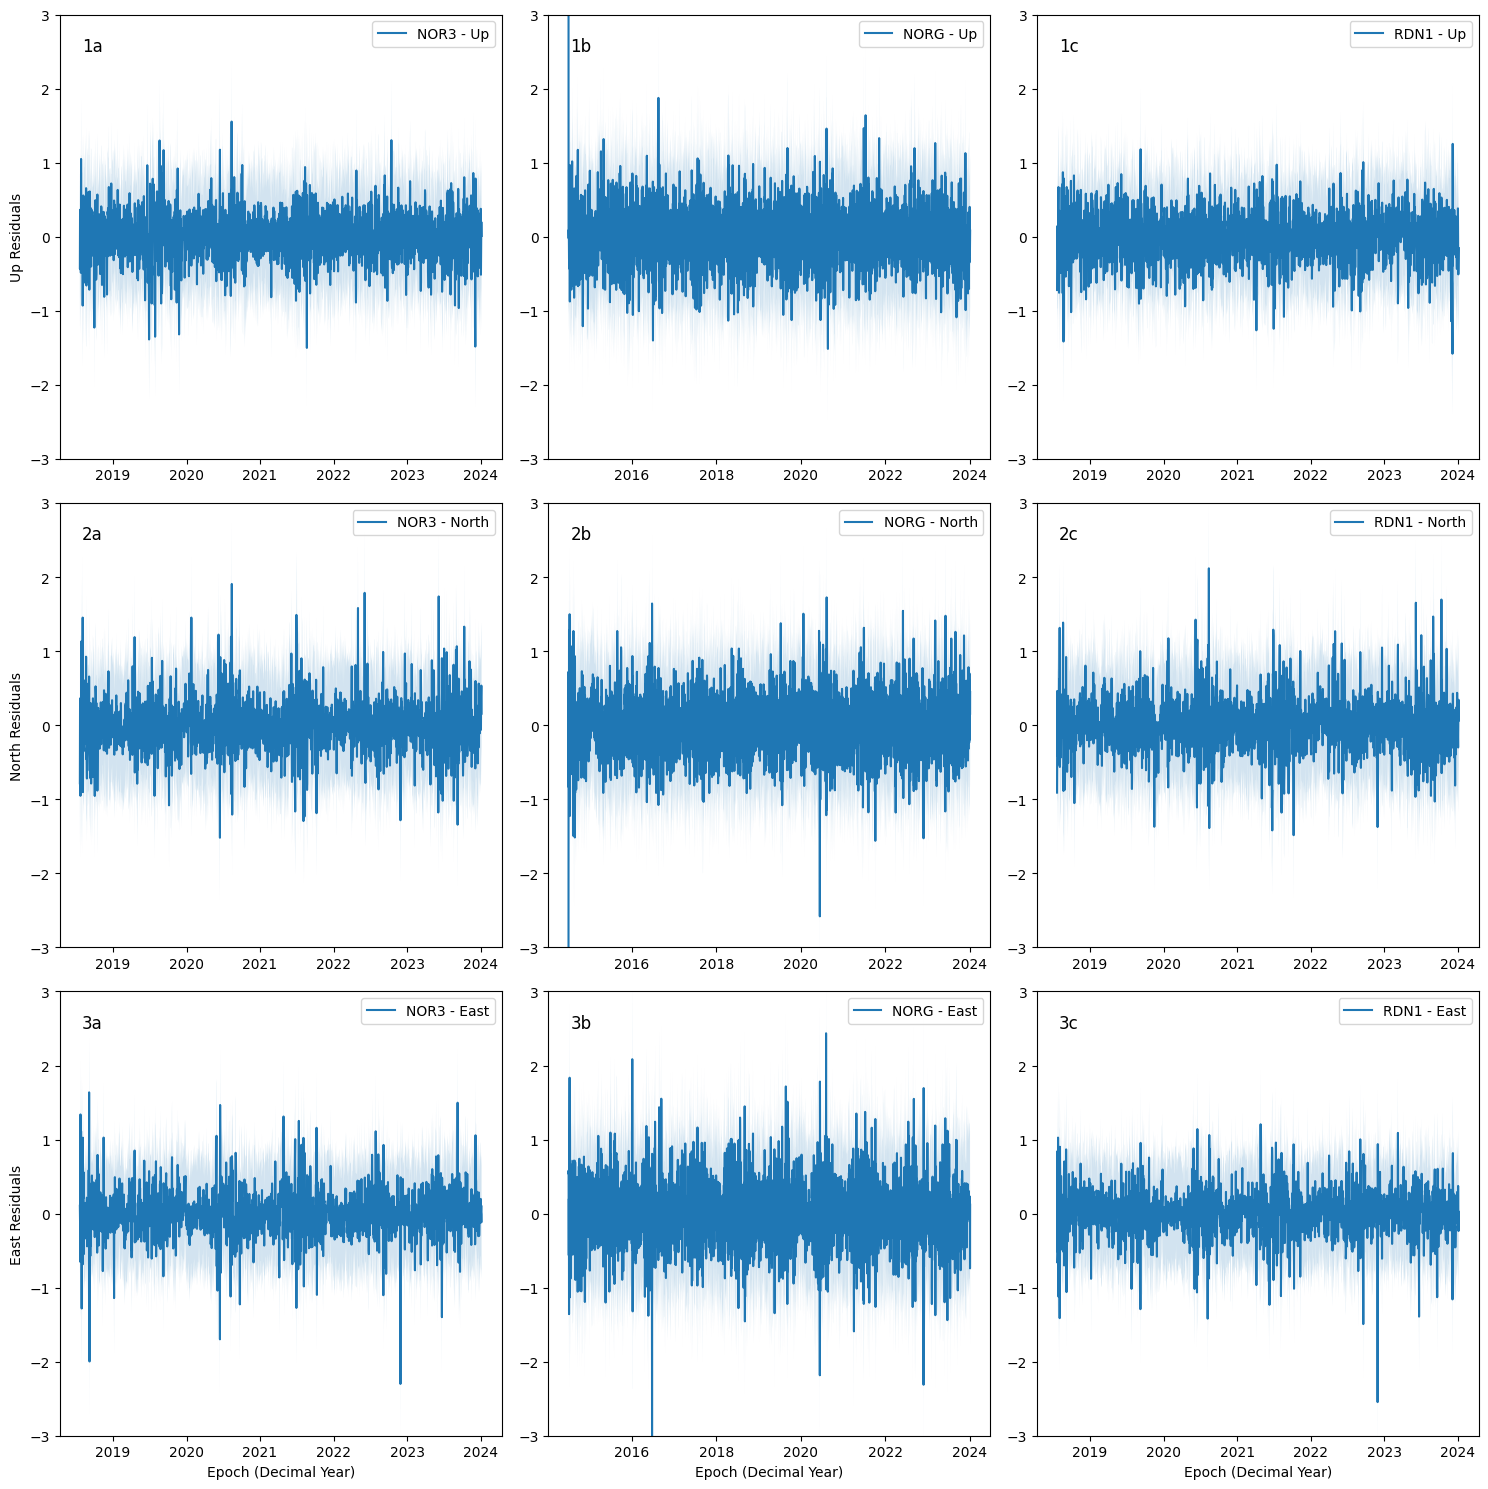

Outliers (Station, Direction, Time, Residual):
('NORG', 'Up', 2014.5023956194386, 10.035519759335859)
('NORG', 'North', 2014.5023956194386, -6.182174421599509)


In [48]:

# Function to plot residuals
def plot_residuals(station, direction, ax, label):
    site_index = station_indices[station]
    if direction == 'Up':
        data_series = obsData[site_index, :, 2]
    elif direction == 'North':
        data_series = obsData[site_index, :, 0]
    elif direction == 'East':
        data_series = obsData[site_index, :, 1]
    
    # Create time series DataFrame
    df = pd.DataFrame({'Epoch': epochDyear, 'Series': data_series})
    df = df[df['Epoch'] >= 2014.5]  # Unified time range

    # Remove NaN and inf values
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Detrend the series
    detrended_series = detrend(df['Series'])

    # Define state space model
    model_settings = {
        'irregular': True,
        'level': True,
        'stochastic_level': True,
        'trend': True,
        'stochastic_trend': True,  
        'freq_seasonal': [{'period': 365, 'harmonics': 1}],
        'autoregressive': 2
    }
    ssm = sm.tsa.UnobservedComponents(detrended_series, **model_settings)

    # Fit the model
    ssm_res = ssm.fit(method='powell', disp=True)

    # Extract residuals
    residuals = ssm_res.resid
    sigma = np.std(residuals)
    
    # Plot residuals
    ax.plot(df['Epoch'], residuals, label=f'{station} - {direction}')
    ehat_int = norm.ppf(.995, scale=sigma)
    ehatplus = residuals + ehat_int
    ehatmin = residuals - ehat_int
    ax.fill_between(df['Epoch'], ehatplus, ehatmin, alpha=0.2)
    ax.set_ylim(-3, 3)  # Set y-axis range
    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize=12, verticalalignment='top')  # Add label

    # Find residuals greater than 4 or less than -4
    outliers_indices = np.where((residuals > 4) | (residuals < -4))[0]
    for idx in outliers_indices:
        outliers.append((station, direction, df['Epoch'].iloc[idx], residuals[idx]))

# Create subplots for comparison
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

labels = ['1a', '1b', '1c', '2a', '2b', '2c', '3a', '3b', '3c']
label_index = 0

for i, direction in enumerate(directions):
    for j, station in enumerate(stations):
        ax = axs[i, j]
        plot_residuals(station, direction, ax, labels[label_index])
        label_index += 1
        if j == 0:
            ax.set_ylabel(f'{direction} Residuals')
        if i == 2:
            ax.set_xlabel('Epoch (Decimal Year)')
        ax.legend()

plt.tight_layout()
plt.show()

# Print information of residuals greater than 4 or less than -4
print("Outliers (Station, Direction, Time, Residual):")
for outlier in outliers:
    print(outlier)